In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#下面的`scipy`是一个用于科学计算和技术计算的Python库，提供了许多高级的数学函数和便利的操作，包括数值积分、插值、优化、图像处理、统计等。
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）。
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。
from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
from plotting import newfig, savefig  #从自定义的plotting.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting.py文件中
from mpl_toolkits.mplot3d import Axes3D #`mpl_toolkits.mplot3d`是`matplotlib`库的一个模块，用于创建三维图形。`Axes3D`是`mpl_toolkits.mplot3d`模块中的一个类，用于创建一个三维的坐标轴。可以在这个坐标轴上绘制三维的图形，如曲线、曲面等。
import time #一个内置模块，用于处理时间相关的操作。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。

import math
import pandas as pd #pandas用于处理结构化数据
from scipy.io import savemat #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。

np.random.seed(1234)
tf.set_random_seed(1234)

C:\Users\Dell\anaconda3\envs\SNGP_PINN\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Dell\anaconda3\envs\SNGP_PINN\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Dell\anaconda3\envs\SNGP_PINN\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Dell\anaconda3\envs\SNGP_PINN\lib\site-packages\tensorf

In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self,X_f, X_bound, layers, lb, ub,gamma=0.5): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数
        self.activateFunction = tf.tanh
        self.num_of_GP =1024
        
        self.gamma =  gamma
        
        self.lb = lb
        self.ub = ub
        self.X_f = X_f # 配位点数据
        self.X_bound = X_bound # 边界点数据
        
        
        # 初始化神经网络
        self.layers = layers # 神经网络的层数
        self.weights, self.biases, self.beta = self.initialize_NN(layers) # 初始化神经网络的权重和偏置，返回初始化的偏置、正则化+初始化的权重和回归的权重
        
        #使用TensorFlow库创建占位符，用于存储输入和输出数据。占位符是TensorFlow中的一个特殊对象，允许在运行时将数据传递给TensorFlow计算图。可以将占位符看作是一个变量，但不需要提供初始值。相反只需要在运行计算图时提供一个值。使用feed_dict参数来为占位符提供值。
            #例如，如果x是一个占位符，可以使用feed_dict={x: 1.0}来为它提供值。这个值可以是一个单独的数字，也可以是一个数组。        
        #每个占位符都使用了tf.placeholder函数进行创建。该函数接受两个参数,第一个是数据类型,这里都是tf.float32,表示占位符的数据类型是浮点数。第二个参数是形状,其中None表示这一维的长度可以是任意的，self.X_f.shape[1]表示这一维的长度是self.X_f的列数。  
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.X_f.shape[1]])     
        #None表示行的长度可以是任意的，self.X_bound.shape[1]表示列数是self.X_bound的列数。
        self.x_bound_tf =  tf.placeholder(tf.float32, shape=[None, self.X_bound.shape[1]])  
        



        # standard normal distribution，标准正态分布
        self.GP_W= tf.random.normal(shape=(100,self.num_of_GP),mean =0,stddev=1,dtype=tf.float32) #生成一个形状为(100,self.num_of_GP)的正态分布随机数，均值为0，标准差为1
        self.GP_W= np.sqrt(2*self.gamma)*tf.Session().run(self.GP_W) # this is very important，这一步乘上了一个系数，这个系数是一个常数，用于调整正态分布随机数的大小
        #uniformly distributed，均匀分布
        self.GP_b= tf.random.uniform(shape=(1,self.num_of_GP),minval=0,maxval=2*math.pi,dtype=tf.float32) #生成一个形状为(1,self.num_of_GP)的均匀分布随机数，范围是[0,2*pi]
        self.GP_b= tf.Session().run(self.GP_b)  # this is very important
        



        # tf Graphs，这里是使用TensorFlow库进行神经网络前向传播的部分（预测部分）。 

        self.u_pred, _ =  self.net_u(self.x_tf) # Calculate predicted value，是调用net_u函数,将self.x_tf作为参数传入,然后将返回的结果赋值给self.u_pred，计算得到预测值
        self.f_u_pred  = self.net_f_u(self.x_tf) # Calculate the loss value of ODE，是调用net_f_u函数,将self.x_tf作为参数传入,然后将返回的结果赋值给self.f_u_pred，计算得到ODE的损失值
        self.u_pred_bound,_ = self.net_u(self.x_bound_tf) # Calculate the value of the boundary point，是调用net_u函数,将self.x_bound_tf作为参数传入,然后将返回的结果赋值给self.u_pred_bound，计算得到边界点的值
        
        # 调用下面的函数，找到高斯过程的特征参数
        self.Hidden_pred, self.Fai_pred = self.net_for_hidden_features(self.x_tf)
                


        # Loss，这里是使用TensorFlow库计算损失函数的部分，训练目标是最小化损失函数，这里的损失函数由两部分组成，分别是初始条件、边界条件、微分方程两边的残差。每一部分都是预测值与真实值之间的差的平方的均值（均方误差）
        #tf.reduce_mean是TensorFlow库中的一个函数，用于计算张量的均值。它接受一个参数，即张量，可以是一个一维数组，也可以是一个多维数组。它会返回一个标量，即这个张量的均值。
        #tf.square是TensorFlow库中的一个函数，用于计算张量的平方。它接受一个参数，即张量，可以是一个一维数组，也可以是一个多维数组。它会返回一个与输入张量形状相同的张量，其中每个元素都是输入张量对应元素的平方。
        #这里的+ \表示将两行代码连接成一行，这是Python中的行连接符，用于将一行代码分成多行书写。
        self.loss =tf.reduce_mean(tf.square(self.f_u_pred)) + \
                   1*tf.reduce_mean(tf.square(self.u_pred_bound)) 
        
        # Optimizers，这里是使用TensorFlow库进行优化的部分，使用L-BFGS-B。L-BFGS-B是一种基于梯度的优化方法，它使用了拟牛顿法来寻找损失函数的最小值。
        #首先用tf.contrib.opt.ScipyOptimizerInterface函数创建了一个优化器self.optimizer，它使用了L-BFGS-B方法，最大迭代次数为50000次，最大函数调用次数为50000次，最大相关矩阵大小为50，最大线搜索次数为50，终止条件为1.0 * np.finfo(float).eps。
              #tf.contrib.opt.ScipyOptimizerInterface是TensorFlow中的函数，提供了一个接口，可以使用优化算法来最小化TensorFlow的损失函数，接受三个参数，第一个参数是损失函数（这里是self.loss）,第二个参数是优化方法，这里是L-BFGS-B，第三个参数options是一个字典，用于指定优化器的参数。
              #这里maxiter表示最大迭代次数，maxfun表示最大函数调用次数，maxcor表示每次迭代中使用的最大修正因子数量，maxls表示每次迭代中最大线搜索次数，ftol表示终止条件，这里是1.0*np.finfo(float).eps，其中np.finfo(float).eps表示浮点数的精度，1.0 * np.finfo(float).eps表示浮点数的精度乘以1.0。
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})

        #第二个优化器是Adam优化器，它是一种基于梯度的优化方法，使用了自适应学习率。首先用tf.train.AdamOptimizer函数创建了一个优化器self.optimizer_Adam，然后使用self.optimizer_Adam.minimize函数最小化了损失函数self.loss。
        self.optimizer_Adam = tf.train.AdamOptimizer()
        #定义一个基于第二个优化器Adam优化器训练操作，用于最小化损失函数self.loss。
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        #使用tf.Session创建了一个名为tf.sess的会话。接受一个config参数，这是一个tf.ConfigProto对象，用于设置会话的配置选项。这里设置了两个选项：
              #allow_soft_placement：如果设置为True，那么当某些操作无法在GPU上执行时，TensorFlow会自动将它们放在CPU上执行；
              #log_device_placement：如果设置为True，那么在日志中会记录每个节点被安排在哪个设备上执行
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        #使用tf.global_variables_initializer函数创建了一个初始化所有全局变量的操作（Tensorflow中所有变量在使用之前都需要进行初始化）
        init = tf.global_variables_initializer()
        #sess.run是会话的一个方法，用于执行图中的操作或计算张量的值。这里是执行初始化
        self.sess.run(init)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    #定义了一个名为`initialize_NN'的函数/方法，用于初始化神经网络的权重和偏置，最后返回初始化的偏置、正则化+初始化的权重和回归的权重（作用于输出层）     
    def initialize_NN(self, layers): #接受神经网络的层数作为参数
        #定义两个空列表，用于存储权重和偏置
        weights = []
        biases = []
        num_layers = len(layers) #获取神经网络的层数
        
        beta = self.xavier_init(size=[self.num_of_GP, 1])  # weights used for regression，用于回归的权重
        
        for l in range(0,num_layers-2): #使用循环遍历神经网络的每一层（除了输出层和最后一个隐藏层）
            W = self.xavier_init(size=[layers[l], layers[l+1]]) #初始化该层的权重，使用了xavier_init函数(该函数定义在下面)进行Xaiver初始化，权重的形状是layers[l]*layers[l+1]，其中layers[l]是上一层的神经元数量，layers[l+1]是当前层的神经元数量。
              #tf.Variable(initial_value, dtype=None, name=None)函数用于创建一个变量，接受三个参数，第一个参数initial_value是变量的初始值，第二个参数dtype是变量的数据类型，第三个参数name是变量的名称。
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32) #初始化该层的偏置b，使用了tf.Variable函数，将偏置b初始化为一个形状为[1,layers[l+1]]的全0数组，其中layers[l+1]是当前层的神经元数量
              #list.append(element)是Python中的一个方法，用于向列表中添加元素（添加到列表末尾）。list是要添加元素的列表，element是要添加的元素（然和类型的参数均可）。
            weights.append(W) #将初始化的权重和偏置添加到weights和biases列表中
            biases.append(b)    
            
        for l in range(1,num_layers-2):   # During initialization, the norm is required to be smaller than 1.  ...初始化权重过程中，需要保证范数小于1，因此要做正则化，正则化的层包括除了第一层之外的所有层（除了输出层和最后一个隐藏层）
                                           #The first layer does not require regularization，第一层不需要正则化
            W = weights[l]   #获取第l层的权重
            normalized = tf.norm(tf.transpose(W), ord=2) #计算权重矩阵 W 的 L2 范数（即欧几里得范数）。这里使用了 tf.norm 函数，并对权重矩阵进行了转置
            weights[l] = tf.where(tf.math.greater(normalized,0.99),0.99*W/normalized, W) # Determine whether it is greater than the threshold，确定第l层的权重矩阵范数是否大于阈值，大于阈值的改为0.99
            #使用tf.where函数判断范数是否大于0.99，如果大于0.99，则将权重矩阵 W 乘以 0.99/范数（即将W，第l层的权重矩阵缩放到0.99，否则保持不变）  

            
        return weights, biases, beta #返回初始化的偏置、正则化+初始化的权重和回归的权重（作用于输出层）
        
    #定义了一个名为xavier_init的函数/方法，用于初始化神经网络的权重(在神经网络参数初始化中实现，见上面)。这个函数使用了Xavier初始化方法，这是一种常用的权重初始化方法，可以帮助我们在训练深度神经网络时保持每一层的激活值的分布相对稳定。    
    def xavier_init(self, size): #接受一个参数size，这是一个列表，包含了权重的形状
        in_dim = size[0] #输入维度是size的第一个数
        out_dim = size[1]   #输出维度是size的第二个数     
        xavier_stddev = np.sqrt(2/(in_dim + out_dim)) #计算标准差
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32) #返回一个变量，类型为32位浮点，初始值为截断正态分布，标准差为xavier_stddev，形状为[in_dim, out_dim]，其中in_dim和out_dim分别是输入维度和输出维度
    
    #定义了一个名为neural_net的函数/方法，用于实现神经网络的输出。这个方法接受四个参数，分别是X，weights、biases和beta，其中X是输入数据，weights和biases是神经网络的权重和偏置，beta是用于回归的权重。最后得到输出层的输出Y。
    def neural_net(self, X, weights, biases, beta):    
        
        num_layers = len(weights) + 2  #计算神经网络的层数并返回到num_layers，其值位权重矩阵的长度（行数）加2，因为还有最后一个隐藏层和输出层
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0 #这里H是X经过归一化处理后的结果，将X映射到了[-1,1]区间内
        W = weights[0] #获取第一层的权重
        b = biases[0] #获取第一层的偏置
        H = (tf.add(tf.matmul(H, W), b)) #计算第一层的输出HW+b

        for l in range(1,num_layers-2): #使用循环遍历神经网络的每一层（除了输入层、输出层和最后一个隐藏层）
            W = weights[l] #获取第l层的权重
            normalized = tf.norm(tf.transpose(W), ord=2) #计算权重矩阵 W 的 L2 范数（即欧几里得范数）。这里使用了 tf.norm 函数，并对权重矩阵进行了转置

            W = tf.where(tf.math.greater(normalized,0.99),0.99*W/normalized, W) # Determine whether it is greater than the threshold，确定第l层的权重矩阵范数是否大于阈值，大于阈值的改为0.99
            #使用tf.where函数判断范数是否大于0.99，如果大于0.99，则将权重矩阵 W 乘以 0.99/范数（即将W，第l层的权重矩阵缩放到0.99，否则保持不变）
            b = biases[l] #获取第l层的偏置
            H1 = self.activateFunction(tf.add(tf.matmul(H, W), b)) #计算第l层的输出，激活函数为tanh
            H =tf.add(H, H1) #将第l层的输出与H（前一层的输出）相加，得到第l层的最终输出

        H = tf.add(tf.matmul(H,self.GP_W),self.GP_b) #计算最后一个隐藏层的输出，这里是将前一层的输出H乘以GP_W加上GP_b
        H = tf.sqrt(2/self.num_of_GP)*tf.cos(H) #将最后一个隐藏层的输出H变为cos(H)乘上一个系数，这个系数是一个常数

        Y = tf.matmul(H, beta) #计算输出层的输出，将最后一个隐藏层的输出H·beta
        return Y #返回输出层的输出
    
    #定义了一个名为net_for_hidden_features的函数/方法，用于找到高斯过程的特征参数。这个方法接受一个参数X，是输入数据，返回最后一个隐藏层的坐标（最后一个隐藏层的输出）和随机过程的特征（最后一个隐藏层调整后的输出，即乘上一个系数并cos）
    def net_for_hidden_features(self,x): # Find the characteristic parameters of Gaussian process，找到高斯过程的特征参数
        weights = self.weights #获取神经网络除了最后一个隐藏层和输出层的权重
        biases = self.biases #获取神经网络除了最后一个隐藏层和输出层的偏置
        X = x #获取输入数据
        
        num_layers = len(weights) + 2  #计算神经网络的层数并返回到num_layers，其值位权重矩阵的长度（行数）加2，因为还有最后一个隐藏层和输出层
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0 #这里H是X经过归一化处理后的结果，将X映射到了[-1,1]区间内
        W = weights[0] #获取第一层的权重
        b = biases[0] #获取第一层的偏置
        H = (tf.add(tf.matmul(H, W), b))   #计算第一层的输出HW+b

        for l in range(1,num_layers-2): #使用循环遍历神经网络的每一层（除了输入层、输出层和最后一个隐藏层）
            W = weights[l] #获取第l层的权重
            normalized = tf.norm(tf.transpose(W), ord=2) #计算权重矩阵 W 的 L2 范数（即欧几里得范数）。这里使用了 tf.norm 函数，并对权重矩阵进行了转置
            # Determine whether it is greater than the threshold
            W = tf.where(tf.math.greater(normalized,0.99), 0.99*W/normalized, W) # Determine whether it is greater than the threshold，确定第l层的权重矩阵范数是否大于阈值，大于阈值的改为0.99
            #使用tf.where函数判断范数是否大于0.99，如果大于0.99，则将权重矩阵 W 乘以 0.99/范数（即将W，第l层的权重矩阵缩放到0.99，否则保持不变）
            b = biases[l] #获取第l层的偏置
            H1 = self.activateFunction(tf.add(tf.matmul(H, W), b)) #计算第l层的输出，激活函数为tanh
            H =tf.add(H, H1) #将第l层的输出与H（前一层的输出）相加，得到第l层的最终输出

        H1 = tf.add(tf.matmul(H,self.GP_W),self.GP_b) #计算最后一个隐藏层的输出，这里是将前一层的输出H乘以GP_W加上GP_b
        Fai = tf.sqrt(2/self.num_of_GP)*tf.cos(H1) #将最后一个隐藏层的输出H1变为cos(H1)乘上一个系数，这个系数是一个常数
 
        
        return H, Fai # Obtain the last hidden layer coordinates and random process characteristics，获取最后一层隐藏层的坐标和随机过程的特征
        #返回最后一层隐藏层的坐标（最后一个隐藏层的输出）和随机过程的特征（最后一个隐藏层调整后的输出，即乘上一个系数并cos）
    
    def net_u(self, x):  # Calculate values and derivatives，计算值和导数
        X = x #获取输入数据
        u = self.neural_net(X, self.weights, self.biases, self.beta) #计算神经网络的输出
        u_x = tf.gradients(u, x)[0] #计算u关于x的导数
        return u, u_x

    def net_f_u(self, x):  # Calculate loss，计算损失
        u, u_x= self.net_u(x) #得到神经网络的输出和导数
        
        PI = np.pi #获取π的值
        u_xx = tf.gradients(u_x, x)[0] #计算u_x关于x的导数
        fx = -1*PI**2*tf.sin(PI*x)-PI*tf.cos(PI*x)*(tf.sin(PI*x))**2 #计算f(x)的值
        m_loss =  u_xx-u**2 *u_x -fx #计算损失函数
        
        return m_loss #返回损失函数
    
    def callback(self, loss):  #定义了一个名为callback的函数/方法，打印损失值并记录迭代次数
        print('Loss:', loss) #打印损失值

    #定义了一个名为train的函数/方法，用于训练神经网络。这个方法接受参数为迭代次数nIter    
    def train(self, nIter):
        #创建一个名为tf_dict的字典，该字典将TensorFlow占位符映射到它们对应的数据。创建tf_dict的目的是为了在运行TensorFlow的计算图时，能够将数据传递给占位符。例如，当运行self.sess.run(self.train_op_Adam, tf_dict)时，tf_dict中的数据就会被传递给对应的占位符，然后在计算图中使用
            #字典语法：dict = {key1: value1, key2: value2, ...}：key1、key2等是字典的键，value1、value2等是对应的值（这里键是占位符，值是对应的数据）。
        tf_dict = {self.x_tf: self.X_f,
                   self.x_bound_tf: self.X_bound}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()

        #使用优化器来最小化损失函数，第一个参数表示TensorFlow会话，第二个参数表示将数据传递给占位符的字典，fetches表示要获取的结果（这里只获取了损失函数的值），最后一个参数表示每次优化迭代后调用的回调参数，这里是之前定义的，用来打印损失函数                                                                                                                                                                                                                                    
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star): # Start prediction
        #创建一个字典，其中包含了两个键值对，键是 TensorFlow 的占位符（self.x_tf和self.x_bound_tf），值是X_star和X_bound。这个字典将被用于在下面的TensorFlow 会话中给placeholder赋值，用以运行计算图
        tf_dict = {self.x_tf: X_star, self.x_bound_tf: self.X_bound}
        #使用 self.sess.run方法来给placeholder赋值并运行计算图，获取self.u_pred(神经网络的输出)的计算结果。并将结果保存在u_star中
        u_star = self.sess.run(self.u_pred, tf_dict)  
               
        return u_star #返回神经网络的输出
    

    def obtain_Hidden_and_Fai(self, X_star):
        #创建一个字典，其中包含了一个键值对，键是 TensorFlow 的占位符（self.x_tf），值是X_star。这个字典将被用于在下面的TensorFlow 会话中给placeholder赋值，用以运行计算图
        tf_dict = {self.x_tf: X_star}
        #使用 self.sess.run方法来给placeholder赋值并运行计算图，获取self.Hidden_pred和self.Fai_pred的计算结果。并将结果保存在Hidden_pred和Fai_pred中
        Hidden_pred = self.sess.run(self.Hidden_pred, tf_dict)
        Fai_pred = self.sess.run(self.Fai_pred, tf_dict)
        return Hidden_pred, Fai_pred

In [3]:
noise = 0.0        

# Doman bounds
lb = np.array([-1.0])
ub = np.array([1.0])
X_bound = np.array([[-1.0],[1.0]] )

N0 = 50
N_b = 50
N_f = 10
gamma = 5.0

layers = [1, 100, 100,1]

x_t = np.linspace(-1,1,100)
X_f = lb + (ub-lb)*lhs(1, N_f)
for l in range(X_f.shape[0]):
    temp_1 = X_f[l]
    temp_2 = np.abs(temp_1 - x_t)
    inx = np.argmin(temp_2)
    X_f[l] = x_t[inx]

model = PhysicsInformedNN(X_f,X_bound, layers, lb, ub,gamma)

start_time = time.time()                
model.train(5000)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



It: 0, Loss: 3.923e+01, Time: 0.37
It: 100, Loss: 3.189e-02, Time: 0.21
It: 200, Loss: 7.994e-04, Time: 0.21
It: 300, Loss: 3.961e-06, Time: 0.20
It: 400, Loss: 2.273e-09, Time: 0.20
It: 500, Loss: 2.834e-12, Time: 0.20
It: 600, Loss: 7.824e-13, Time: 0.20
It: 700, Loss: 6.161e-13, Time: 0.20
It: 800, Loss: 1.386e-12, Time: 0.20
It: 900, Loss: 6.152e-12, Time: 0.20
It: 1000, Loss: 3.684e-12, Time: 0.20
It: 1100, Loss: 5.359e-12, Time: 0.20
It: 1200, Loss: 3.035e-12, Time: 0.21
It: 1300, Loss: 3.751e-12, Time: 0.20
It: 1400, Loss: 1

In [4]:
lb = np.array([-1.0])
lb = np.reshape(lb,[1,1])
ub = np.array([1.0])
ub = np.reshape(ub,[1,1])
X_know = np.concatenate((lb,ub,X_f),0) #  known point

In [5]:
u_pred= model.predict(X_know)  #  Predicted value of known point
f_know = u_pred

In [6]:
x_t =np.reshape(x_t,[x_t.shape[0],1])

In [7]:
Hidden_pred_small, Fai_pred_small = model.obtain_Hidden_and_Fai(X_know)
X = Hidden_pred_small

In [8]:
Hidden_pred_all, Fai_pred_all = model.obtain_Hidden_and_Fai(x_t)
X_xing = Hidden_pred_all

In [9]:
n_xing = X_xing.shape[0]
Cov_xing_xing = np.zeros(shape=(n_xing,n_xing), dtype=float)
for i in range(n_xing):
    for j in range(n_xing):
        xi = X_xing[i:i+1,:]
        xj = X_xing[j:j+1,:]
        dij = np.sum((xi-xj)**2)
        Cov_xing_xing[i][j] = np.exp(-gamma*dij)

In [10]:
n = X.shape[0]
Cov_X_X = np.zeros(shape=(n,n), dtype=float)
for i in range(n):
    for j in range(n):
        xi = X[i:i+1,:]
        xj = X[j:j+1,:]
        dij = np.sum((xi-xj)**2)
        Cov_X_X[i][j] = np.exp(-gamma*dij)

In [11]:
Cov_xing_X = np.zeros(shape=(n_xing,n), dtype=float)
for i in range(n_xing):
    for j in range(n):
        xi = X_xing[i:i+1,:]
        xj = X[j:j+1,:]
        dij = np.sum((xi-xj)**2)
        Cov_xing_X[i][j] = np.exp(-gamma*dij)

In [12]:
Cov_X_xing = Cov_xing_X.T

In [13]:
rho_orig = Cov_X_X
xishu = 100000000
rho = rho_orig*xishu 
u, s, v = np.linalg.svd(rho)
inv_s=np.linalg.inv(np.diag(s))
t1= np.matmul(v.T, inv_s) 
t2= np.matmul(t1, u.T)
t3= np.matmul(t2, rho) # Check whether the obtained inverse matrix is correct. If it is the identity matrix, it means there is no problem.
inv_rho = t2*xishu  # Inverse of covariance matrix

In [14]:
sigma_2= Cov_xing_xing - np.matmul(np.matmul(Cov_xing_X, inv_rho), Cov_X_xing)

In [15]:
sigma_2 = np.diag(sigma_2)
sigma_2 = np.abs(sigma_2)
sigma = np.sqrt(sigma_2)
sigma = sigma[:,np.newaxis]

In [16]:
PI = np.pi
reall = np.sin(PI*x_t) # Ground truth
prediction= model.predict(x_t)  #  prediction for all points

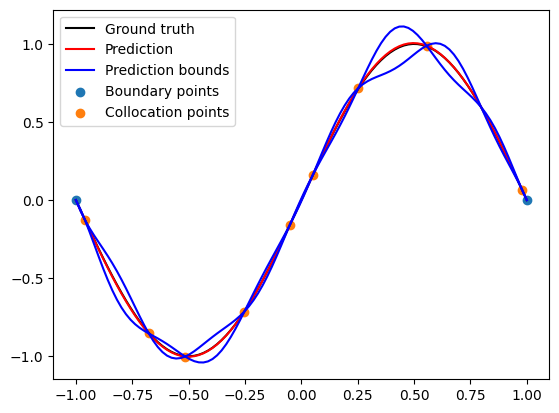

In [17]:
# plot
plt.style.use('default')
plt.figure()

plt.plot(x_t,reall,'k')
plt.plot(x_t,prediction,'r')
plt.plot(x_t,prediction+3*sigma,'b')
plt.scatter(X_know[0:2],f_know[0:2])
plt.scatter(X_know[2:-1],f_know[2:-1])

plt.legend([ 'Ground truth','Prediction','Prediction bounds','Boundary points','Collocation points'], loc = 'best') 
plt.plot(x_t,prediction-3*sigma,'b')